# Configs

In [1]:
import random


random.seed(27)

splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Load data

In [2]:
from utils.prepare_data import getMonitoredPatients
from pandas import Timedelta


patients = getMonitoredPatients()
patients.removePatientAkiEarly(Timedelta(hours=12))

print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


# Transformer

### Seperate static and dynamic

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TransformerSplit(nn.Module):
    def __init__(self, timeSteps, timeFeatures, staticFeatures):
        super(TransformerSplit, self).__init__()

        self.timeSteps = timeSteps
        self.timeFeatures = timeFeatures
        self.staticFeatures = staticFeatures

        # time series layers
        self.fc1_1 = nn.Linear(timeFeatures, 16)
        self.transformerEncoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=16, nhead=2, dim_feedforward=256, batch_first=True
            ),
            num_layers=2,
        )

        # static layers
        self.fc2_1 = nn.Linear(staticFeatures, 16)

        # combine layers
        self.fc1 = nn.Linear(timeSteps + 16, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, seriesInput, staticInput):
        seriesLayer = F.relu(self.fc1_1(seriesInput))
        seriesLayer = self.transformerEncoder(seriesLayer)
        seriesLayer = F.adaptive_max_pool1d(seriesLayer, 1)

        staticLayer = F.relu(self.fc2_1(staticInput))        

        combined = torch.cat([seriesLayer.squeeze(-1), staticLayer], dim=1)
        combined = F.relu(self.fc1(combined))
        combined = self.fc2(combined)

        return combined


# Train (719, 12, 19), (719, 63)
sample_series_input = torch.randn(12, 12, 19)  # (batch_size, timeSteps, timeFeatures)
sample_static_input = torch.randn(12, 63)

model = TransformerSplit(12, 19, 63)
output = model(sample_series_input, sample_static_input)
print(output.shape)

del model
del sample_series_input
del sample_static_input

torch.Size([12, 1])


### Train and eval

In [4]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from utils.class_voter import combineProbas
from utils.dl_train_test import infer, train
from utils.prepare_data import (
    DeepLearningDataPreparer,
    trainValTestPatients,
)
import numpy as np


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 64

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        (
            (npTrainX, staticTrainX, trainY),
            (npValX, staticValX, valY),
            (npTestX, staticTestX, testY),
        ) = preparer.trainValTest(trainPatients, valPatients, testPatients)

        # neg, pos = np.bincount(trainY)
        # weight0 = (1 / neg) * (len(trainY)) / 2.0
        # weight1 = (1 / pos) * (len(trainY)) / 2.0
        # weight = {0: weight0, 1: weight1}

        # create data loader
        trainLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.from_numpy(npTrainX).float(),
                torch.from_numpy(staticTrainX).float(),
                torch.tensor(trainY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            pin_memory=True,
            shuffle=True,
        )
        valLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.from_numpy(npValX).float(),
                torch.from_numpy(staticValX).float(),
                torch.tensor(valY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            pin_memory=True,
            shuffle=False,
        )
        testLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.from_numpy(npTestX).float(),
                torch.from_numpy(staticTestX).float(),
                torch.tensor(testY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            pin_memory=True,
            shuffle=False,
        )
        
        print(f"Train {npTrainX.shape}, {staticTrainX.shape}")

        model = TransformerSplit(npTrainX.shape[1], npTrainX.shape[2], staticTrainX.shape[1])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

        _, trainLosses, valLosses = train(
            model,
            device,
            trainLoader,
            valLoader,
            criterion,
            optimizer,
            epochs=500,
            earlyStopping=10,
        )

        models.append(model)
        train_loss_list.append(trainLosses)
        val_loss_list.append(valLosses)

        predProbas, _ = infer(model, device, testLoader)
        probas.append(predProbas.detach().cpu().numpy())
        torch.save(model.state_dict(), f"result/transformer_split_model/{i}_{ii}.pt")

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

Train (719, 12, 19), (719, 63)


Epoch 1/500 Train Loss: 0.6485 Val Loss: 0.7661
Epoch 2/500 Train Loss: 0.6343 Val Loss: 0.7596
Epoch 3/500 Train Loss: 0.6218 Val Loss: 0.7577
Epoch 4/500 Train Loss: 0.6065 Val Loss: 0.7539
Epoch 5/500 Train Loss: 0.5904 Val Loss: 0.7529
Epoch 6/500 Train Loss: 0.5706 Val Loss: 0.7469
Epoch 7/500 Train Loss: 0.5530 Val Loss: 0.7444
Epoch 8/500 Train Loss: 0.5323 Val Loss: 0.7387
Epoch 9/500 Train Loss: 0.5164 Val Loss: 0.7344
Epoch 10/500 Train Loss: 0.5016 Val Loss: 0.7326
Epoch 11/500 Train Loss: 0.4885 Val Loss: 0.7272
Epoch 12/500 Train Loss: 0.4748 Val Loss: 0.7293
Epoch 13/500 Train Loss: 0.4626 Val Loss: 0.7267
Epoch 14/500 Train Loss: 0.4593 Val Loss: 0.7260
Epoch 15/500 Train Loss: 0.4524 Val Loss: 0.7235
Epoch 16/500 Train Loss: 0.4434 Val Loss: 0.7217
Epoch 17/500 Train Loss: 0.4404 Val Loss: 0.7210
Epoch 18/500 Train Loss: 0.4346 Val Loss: 0.7193
Epoch 19/500 Train Loss: 0.4300 Val Loss: 0.7196
Epoch 20/500 Train Loss: 0.4194 Val Loss: 0.7208
Epoch 21/500 Train Loss: 0.41

In [5]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.7987978072609845 +- 0.025152433234907814 [np.float64(0.8315018315018315), np.float64(0.8090005232862376), np.float64(0.8001560603433329), np.float64(0.7991156580544477), np.float64(0.7542149631190728)]
Accuracy: 0.733063492063492 +- 0.018953444441194248 [0.7422222222222222, 0.7511111111111111, 0.7377777777777778, 0.7377777777777778, 0.6964285714285714]
Specificity: 0.9303885937936819 +- 0.01975433098410665 [np.float64(0.9115646258503401), np.float64(0.9047619047619048), np.float64(0.952054794520548), np.float64(0.952054794520548), np.float64(0.9315068493150684)]
Precision: 0.7384586530264279 +- 0.04926355973896423 [0.717391304347826, 0.72, 0.7941176470588235, 0.7941176470588235, 0.6666666666666666]
Recall: 0.3649139889646219 +- 0.07150295774095229 [0.4230769230769231, 0.46153846153846156, 0.34177215189873417, 0.34177215189873417, 0.2564102564102564]
AUC PR: 0.6750519795354549 +- 0.027825422831463036 [np.float64(0.6903560982415032), np.float64(0.6849973938472164), np.float64(0.69

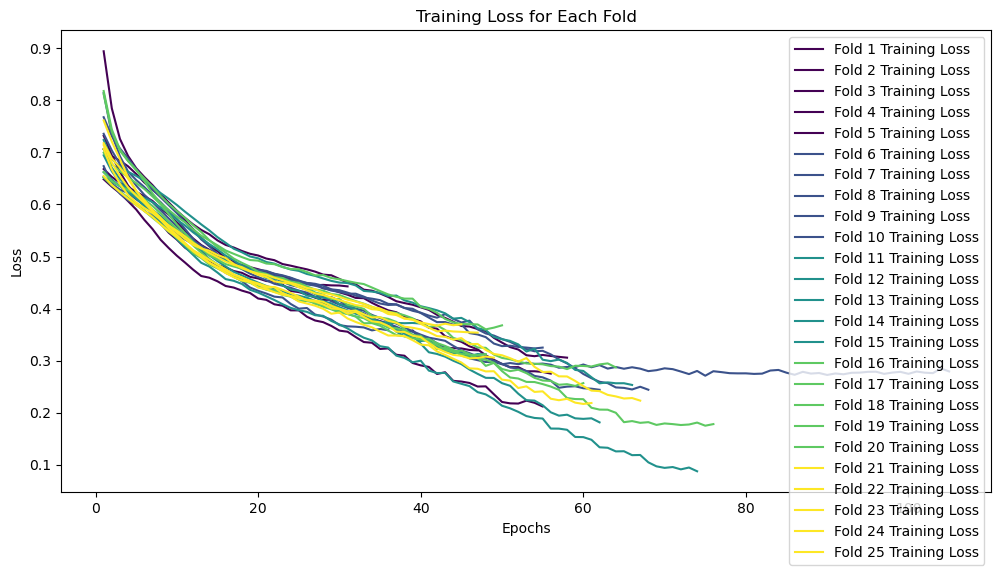

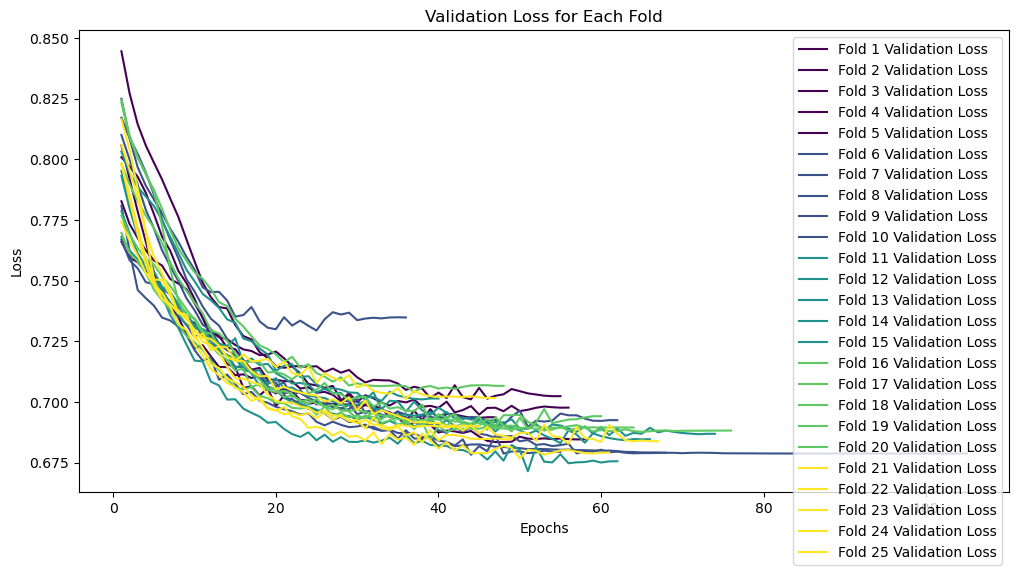

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm 


plt.figure(figsize=(12, 6))

colors = cm.viridis(np.linspace(0,1,5))

for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_split_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_split_val_loss.svg")
plt.show()